In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import tifffile as tiff
import numpy as np
from utils import *
import os
from pathlib import Path
import trackpy as tp
import scipy
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import anderson
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


In [203]:
in_file = r"L:\01_CC-WALK\animations\2d7\trajectories\20240724-123403_WT_aligned_drift_corrected_1.tif"

basename = os.path.basename(in_file)
out_dir = Path(r"L:\01_CC-WALK\animations\2d7\trajectories\out")
os.makedirs(out_dir, exist_ok=True)

In [204]:
take_only_walkers_on_fibre_trajectory(in_file, out_dir / basename)
basename_noext, ext = os.path.splitext(basename)

(2118, 71, 38, 3)


In [205]:
fit_method = "lq"
box_side_length = 9
drift = 0
min_gradient = 1000
px_to_nm = 72
frame_to_s = 0.223

max_link_displacement_px = 2
min_tray_length = 3

In [206]:
#os.environ['HDF5_DISABLE_VERSION_CHECK']='0'
#TOOD add out parameter
!python -m picasso localize {out_dir/basename} --fit-method {fit_method} --box-side-length {box_side_length}  --gradient {min_gradient} --drift {drift} --pixelsize {px_to_nm}



    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           L:\01_CC-WALK\animations\2d7\trajectories\out\20240724-123403_WT_aligned_drift_corrected_1.tif
3        box_side_length 9         
4        fit_method      lq        
5        gradient        1000      
6        drift           0         
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       72        
14       zc                        
15       suffix                    
16       database        0         
-----------------------------


LQ fitting: 100%|██████████| 1500/1500 [00:08<00:00, 179.68task/s]


In [207]:
# Hack -- for now just rename the out file. This is dangerous in multithreaded environment.
out_locs = out_dir / (basename_noext + "_locs.hdf5")
new_suffix = f"__locs__fit_{fit_method}__box_{box_side_length}__gradient_{min_gradient}__drift_{drift}.hdf5"
new_suffix = (
    f"__locs_{fit_method}_box{box_side_length}_grad{min_gradient}_drift{drift}.hdf5"
)
new_out_locs = out_dir / (basename_noext + new_suffix)
#print(new_out_locs)
out_locs.with_suffix(".yaml").rename(new_out_locs.with_suffix(".yaml"))
out_locs.rename(new_out_locs)

WindowsPath('L:/01_CC-WALK/animations/2d7/trajectories/out/20240724-123403_WT_aligned_drift_corrected_1__locs_lq_box9_grad1000_drift0.hdf5')

In [208]:
locs = pd.read_hdf(new_out_locs, "locs")
locs["mass"] = locs.photons

tray = tp.link(locs, max_link_displacement_px)

# count the length of trajectories
tray_by_particle = tray.groupby(["particle"])
tray["length"] = tray_by_particle["particle"].transform("count")

print("mean drift ", tp.compute_drift(tray).mean())

# Exclude very short trays
tray = tray.query(f"length>={min_tray_length}")

steps = tray.groupby(["particle"]).apply(get_steps_from_df)
steps["step_len"] = np.sqrt(steps.dx**2 + steps.dy**2)

suffix = f"__link{max_link_displacement_px}_traylen{min_tray_length}"
base_linked_tray = Path(f'{new_out_locs.with_suffix("")}{suffix}')
tray_out = base_linked_tray.with_suffix(".tray.csv.gz")
tray.to_csv(tray_out)
steps_out = base_linked_tray.with_suffix(".steps.csv.gz")
steps.to_csv(steps_out)

#distribution_check = []
steps_matrix = steps[['dx', 'dy']].to_numpy()
num_columns = steps_matrix.shape[1]  
normal_str = ''
for var_idx in range(num_columns):
    anderson_data = anderson(steps_matrix[:, var_idx])
    is_normal = anderson_data.statistic < anderson_data.critical_values[1]
    #distribution_check += [is_normal]
    if not is_normal:
        normal = f"variable {f'dx' if var_idx == 0 else f'dy'} NOT normally distributed at {anderson_data.significance_level[1]}%\n"
    else:
        normal = f"variable {f'dx' if var_idx == 0 else f'dy'} normally distributed at {anderson_data.significance_level[1]}%\n"
    normal_str += normal 



Frame 2117: 2 trajectories present.
mean drift  y    8.160743
x   -1.559233
dtype: float32


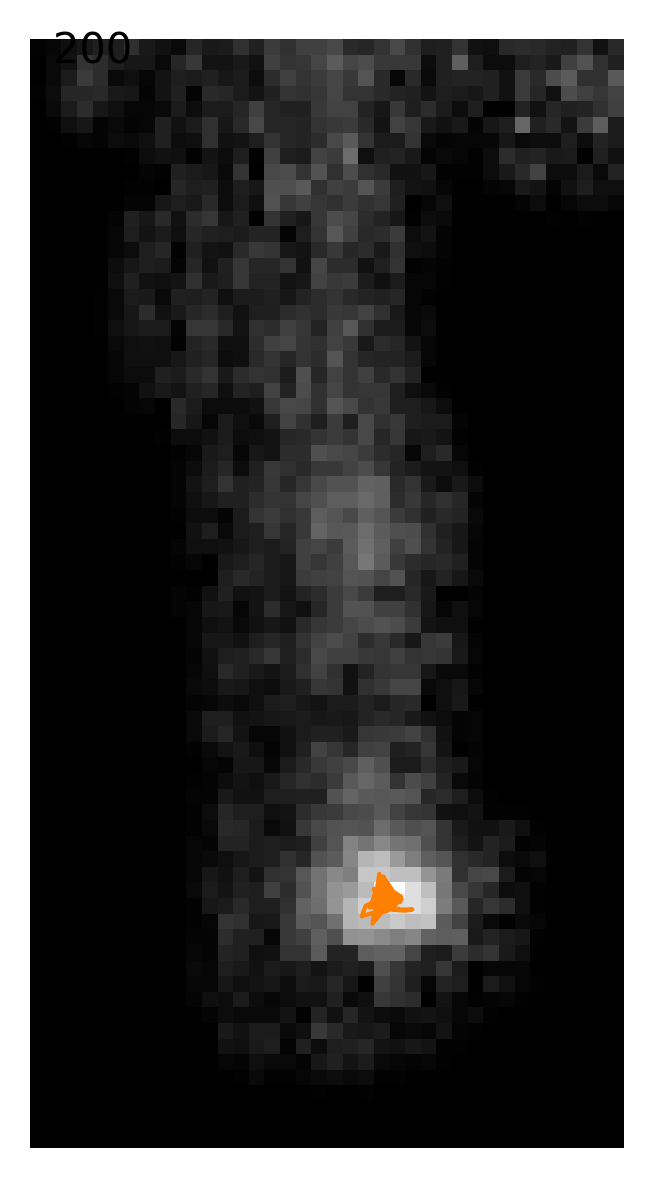

In [210]:

import matplotlib.animation as animation
import matplotlib.colors as mcolors

stack = skio.imread(f'{out_dir}/{basename_noext}.tif')

cmap_bright = plt.colormaps.get_cmap("Set1")
set1_dict = { particle:cmap_bright(i%9) for i, particle in enumerate(list(set(tray.particle)))}

ims = [] 

fig = plt.figure("FRAMES", dpi=300, frameon=False)
ax = fig.add_subplot(111)

for n in range(stack.shape[0]):
    frame = ax.imshow(stack[n].astype('uint8'), cmap = 'Greys_r')
    if n in list(set(tray.frame)):
        t = []
        for k in list(set(tray[(tray["frame"]==n)].particle)):
            bright_color = set1_dict[k]
            t.append(ax.plot(tray[(tray["frame"]<=n) & (tray["particle"]==k)].x, tray[(tray["frame"]<=n) & (tray["particle"]==k)].y, linewidth=1, color=bright_color))
            plt.axis('off')
        number = ax.annotate(n,(1,1))
        artist_obj = [i[0] for i in t]
        artist_obj.append(frame)
        artist_obj.append(number)
        ims.append(artist_obj)

    else:
        ims.append([frame])
    if n >= 200:
        break

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,repeat_delay=1000)

output_path = f'{out_dir}/{basename_noext}_trajectories.mp4'


ani.save(output_path)




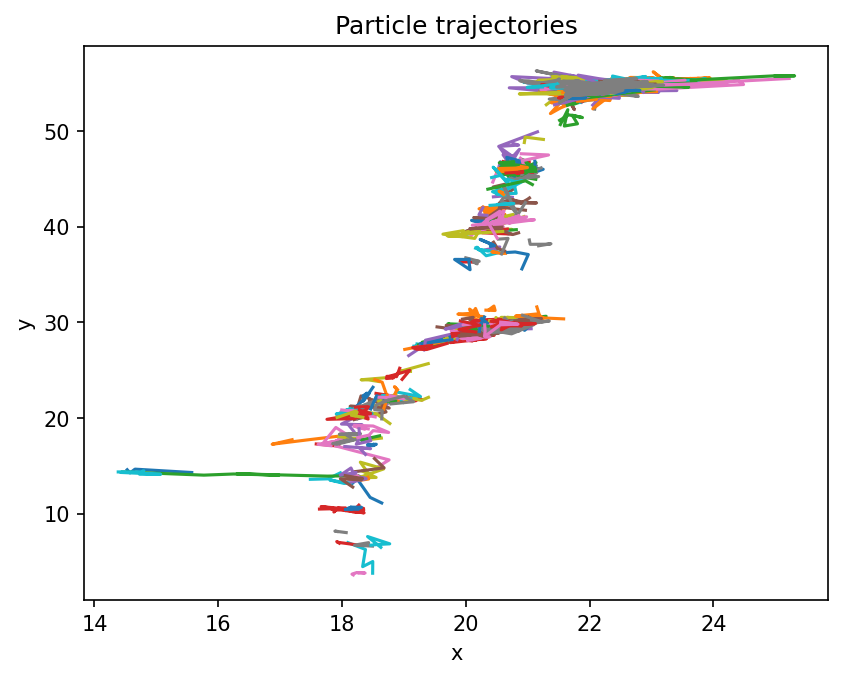

In [211]:
plt.figure()
for i in set(tray.particle):
    plt.plot(tray[tray["particle"]==i].x, tray[tray["particle"]==i].y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle trajectories')
plt.savefig(f'{out_dir}/{basename}_trajectories.png')

In [212]:
x = steps['dx']
y = steps['dy']
bins = (75, 70)
hist, xedges, yedges = np.histogram2d(x, y, bins=(75,50), density=True)
xcent = (xedges[1:] + xedges[:-1])/2
ycent = (yedges[1:] + yedges[:-1])/2
x_grid, y_grid = np.meshgrid(xcent, ycent)
xy = np.stack((x_grid.ravel(), y_grid.ravel())).T


In [213]:
def gaussian_2d(xy, x0, y0, sigmax, sigmay, sigmaxy):
    if xy.shape[-1] != 2 or len(xy.shape) != 2:
        raise ValueError("XY data should have shape (n, 2).")
    mu = np.array([x0, y0])
    sigma = np.array([[sigmax, sigmaxy], [sigmaxy, sigmay]])
    normalization = (((2 * np.pi) ** 2) * np.abs(np.linalg.det(sigma))) ** (-1 / 2)
    bell = np.exp(-0.5 * np.sum(((xy - mu) @ np.linalg.inv(sigma)) * (xy - mu), axis=1))
    return normalization * bell

def cov_to_axes_and_rotation(cov, sorted=True):
    """"Takes a covariance matrix and returns the principle axes and a rotation"""
    (e1, e2), eigen_vec = np.linalg.eig(cov)
    V1,V2 = eigen_vec.T
    
    # Eigenvectors are assumed to be unit and orthogonal
    # print(np.linalg.norm(V1))
    e1 = np.real(e1) # sometimes tiny imaginary components are returned. 
    e2 = np.real(e2) # sometimes tiny imaginary components are returned. 
    if np.isclose(e1, e2):
        # the angle is not well defined
        theta = 0

    else:
        # Are eigenvectors always normalized? 
        theta = np.degrees(np.arctan2(V1[1], V1[0]))
    #if theta>90 and theta <180:
    #     theta = 180 - theta
    #print(theta)

    if sorted: #make sure e1 is always the largest
        if e2>e1:
            (e1, e2) = (e2, e1)
            theta = theta + 90

    return e1, e2, np.mod(theta, 360)

In [214]:
initial_guess = [0, 0, 1, 1, 0]
bounds = ([-np.inf, -np.inf, 0, 0, -1], [np.inf, np.inf, np.inf, np.inf, 1])
popt, _ = curve_fit(gaussian_2d, xy, hist.T.ravel(), initial_guess)
print(popt)
mu = [popt[0], popt[1]]
cov_matrix = [[popt[2], popt[4]], [popt[4], popt[3]]]
e1, e2, rot = cov_to_axes_and_rotation(cov_matrix)

[-0.01211175 -0.00872963  0.09688564  0.11664671  0.02874832]


In [215]:
info = {}
diff_info_out = base_linked_tray.with_suffix(".diff")

info["diff_long_nm_nm_s"] = float(e1*(px_to_nm**2)/(2*frame_to_s))
info["diff_short_nm_nm_s"] = float(e2*(px_to_nm**2)/(2*frame_to_s))
info["time_per_1000nm_s_long_axis"] = 1000 * 1000 / info["diff_long_nm_nm_s"] / 2
info["mean_step_nm_s"] = float(np.sqrt(2 * info["diff_long_nm_nm_s"] * frame_to_s) / frame_to_s)
info["normality_str"] = normal_str
info["anderson_test"] = anderson_data
info["mu_x"] = float(round(mu[0], 3))
info["mu_y"] = float(round(mu[1], 3))
info["sigma_x"] = float(round(cov_matrix[0][0], 3))
info["sigma_y"] = float(round(cov_matrix[1][1], 3))
info["sigma_xy"] = float(round(cov_matrix[0][1], 3))
write_yaml(info, diff_info_out)

variable dx NOT normally distributed at 10.0%
variable dy NOT normally distributed at 10.0%

the means of multivariate normal distrubution are: mu(dx) = -0.012, mu(dy) = -0.009
the standard deviations of the multivariate normal distribution are: sigma(dx) = 0.097, sigma(dy) = 0.117
the covariance of the multivariate normal distribution is: sigma(dxdy) = 0.029
Diff along the long axis (in nm^2/s):  1594.3129076263979
Diff along the short axis (in nm^2/s):  887.6415006373725
time per 1000nm (s):  313.61472243513134
mean step (nm/s) along the long axis: 119.57746640561352


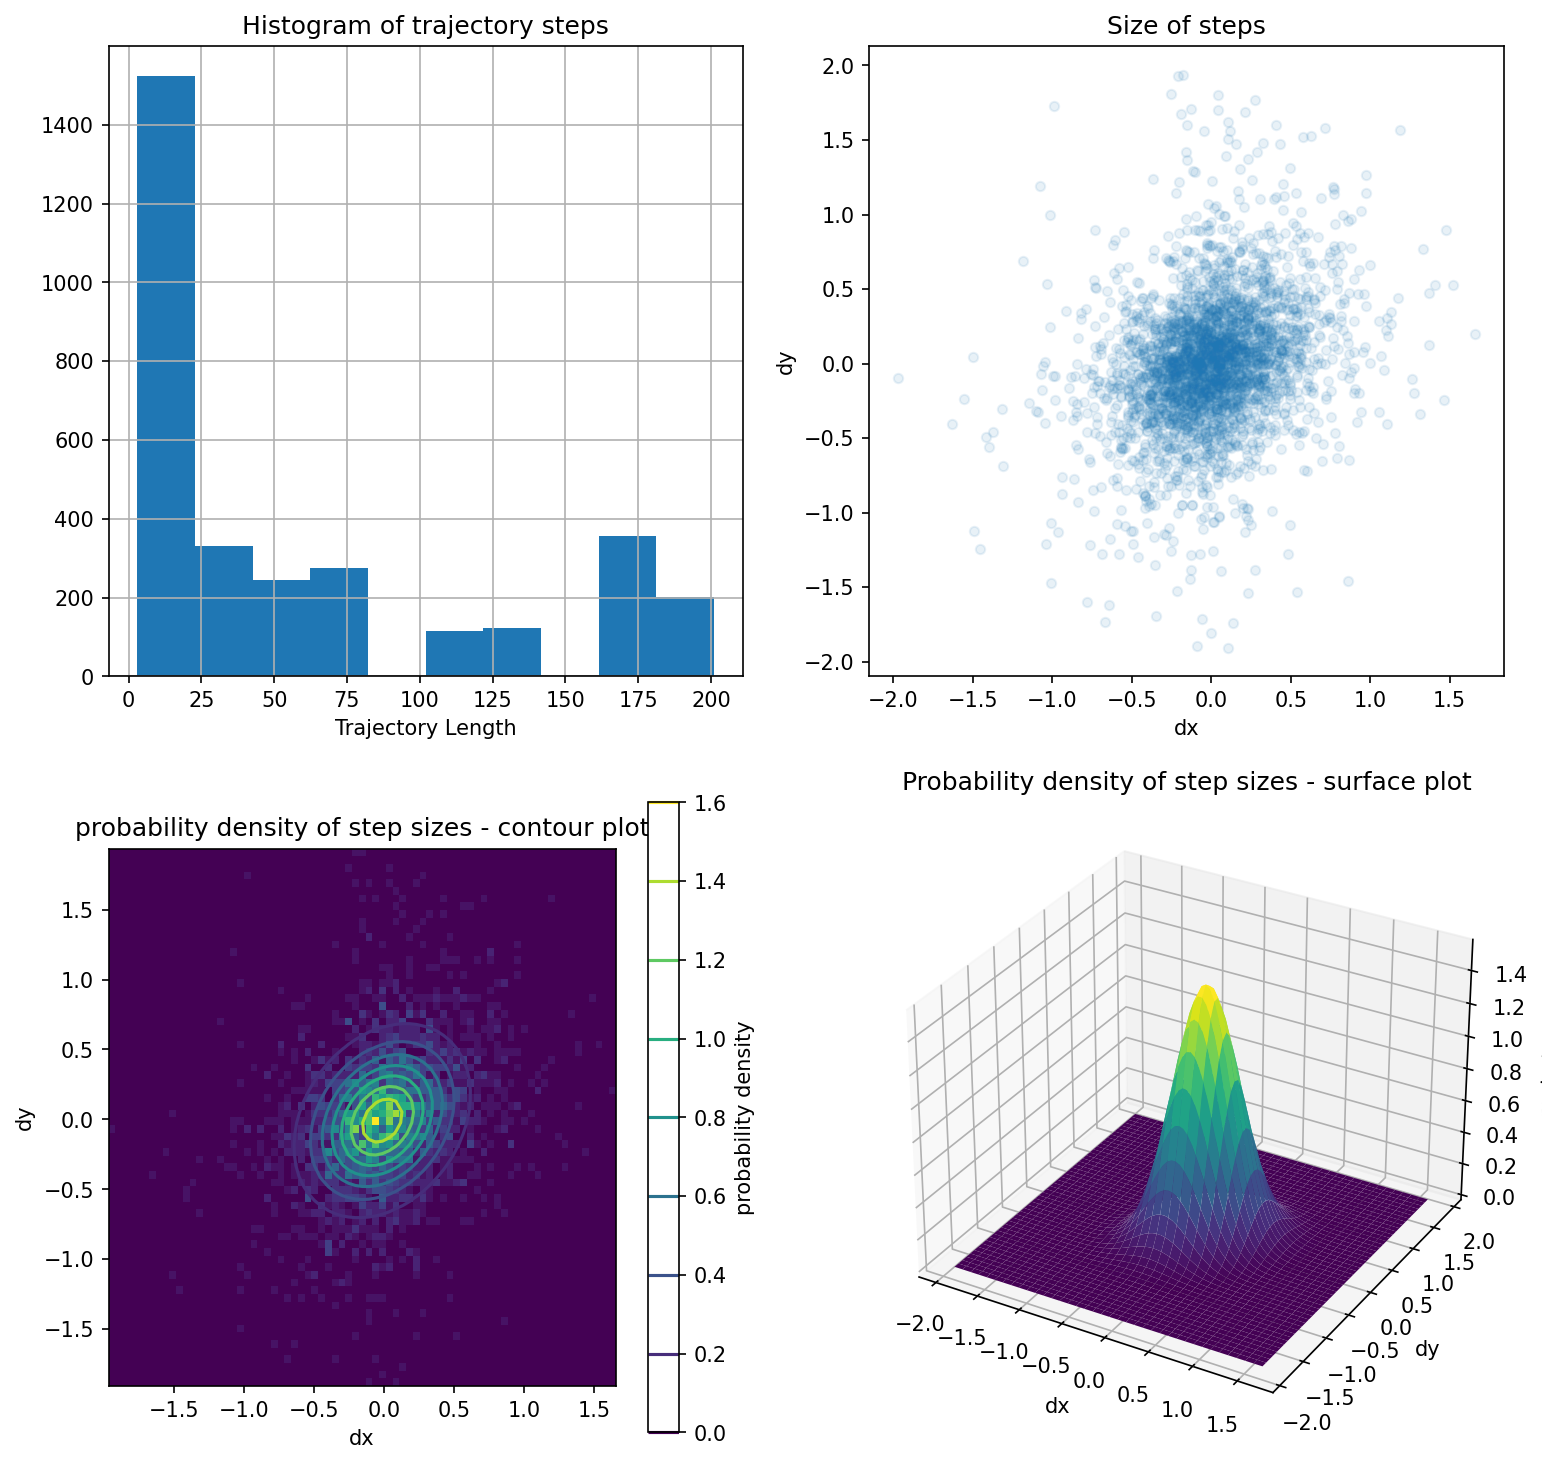

In [216]:
print(normal_str)
print(f'the means of multivariate normal distrubution are: mu(dx) = {mu[0]:.3f}, mu(dy) = {mu[1]:.3f}')
print(f'the standard deviations of the multivariate normal distribution are: sigma(dx) = {cov_matrix[0][0]:.3f}, sigma(dy) = {cov_matrix[1][1]:.3f}')
print(f'the covariance of the multivariate normal distribution is: sigma(dxdy) = {cov_matrix[0][1]:.3f}')
print("Diff along the long axis (in nm^2/s): ", info["diff_long_nm_nm_s"])
print("Diff along the short axis (in nm^2/s): ", info["diff_short_nm_nm_s"])
print("time per 1000nm (s): ", info["time_per_1000nm_s_long_axis"])
print("mean step (nm/s) along the long axis:", info["mean_step_nm_s"])

z = gaussian_2d(xy, *popt)
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224, projection='3d')
plt.sca(ax1)
tray.length.hist()
plt.xlabel("Trajectory Length")
plt.title("Histogram of trajectory steps")
plt.sca(ax2)
steps.plot.scatter("dx", "dy", alpha=0.1, ax=ax2)
plt.title("Size of steps")
plt.sca(ax3)
plt.hist2d(x,y, bins=bins, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.contour(x_grid, y_grid, z.reshape(x_grid.shape), cmap='viridis')
plt.colorbar(label='probability density')
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('probability density of step sizes - contour plot')
plt.sca(ax4)
ax4.plot_surface(x_grid, y_grid, z.reshape(x_grid.shape), cmap='viridis')
plt.xlabel('dx')
plt.ylabel('dy')
ax4.set_zlabel('probability')
plt.title('Probability density of step sizes - surface plot')

fig.savefig(f'{out_dir}/{basename}_2d_fit.png')
